In [2]:
import time
import optax
import haiku as hk
import jax.numpy as jnp
import jax
from torch.utils import data
import numpy as np
from data_utils import SATTrainingDataset, JraphDataLoader
from model import network_definition

NUM_EPOCHS = 10
f=0.0001

# # Make a batched version of the forwarding
# batched_predict = jax.vmap(network.apply, in_axes=(None, 0))


# def loss(params, problems, targets):
#     preds = batched_predict(params, problems)
#     return -jnp.mean(preds * targets)


def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

vmap_one_hot=jax.vmap(one_hot, in_axes=(0,None), out_axes=0)

path='/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/ml_based_sat_solver/BroadcastTestSet_subset/'
sat_data = SATTrainingDataset(path)
train_data, test_data = data.random_split(sat_data, [0.8, 0.2])

train_loader = JraphDataLoader(train_data, batch_size=2, shuffle=True)

network = hk.without_apply_rng(hk.transform(network_definition))
params = network.init(jax.random.PRNGKey(42), sat_data[0][0].graph)

opt_init, opt_update = optax.adam(1e-3)
opt_state = opt_init(params)





ImportError: cannot import name 'network_definition' from 'model' (/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML/ml_based_sat_solver/python/src/model.py)

In [ ]:
@jax.jit
def compute_log_probs(decoded_nodes, mask, candidate):
            a=jax.nn.log_softmax(decoded_nodes) * mask[:, None]
            b= jnp.dot(candidate,a.T)
            return b


vmap_compute_log_probs=jax.vmap(compute_log_probs, in_axes=(None,None, 0), out_axes=0)



@jax.jit
def update(params, opt_state, x, y, f):
            batch_masks=x[0]
            batch_graphs=x[1]
            batch_c=y[0]
            batch_e=y[1]
            #print(len(batch_masks))
            #print(len(batch_graphs))
            #print(len(batch_c))
            #print(len(batch_e))
            #print(batch_e[0])
            #print(batch_e)
            #loss=new_prediction_loss(params, batch_masks[0], batch_graphs[0], batch_c[0], batch_e[0], f)
            #print(loss)
            g=jax.grad(new_prediction_loss)(params, batch_masks[0], batch_graphs[0], batch_c[0], batch_e[0], f)
            #g=jax.grad(batched_loss)(params, *x, c, e, f)
            ####
            updates, opt_state = opt_update(g, opt_state)
            return optax.apply_updates(params, updates), opt_state


@jax.jit
def prediction_loss(params, mask, graph, solution):
        decoded_nodes = network.apply(params, graph)
        solution = one_hot(solution, 2)
        # We interpret the decoded nodes as a pair of logits for each node.
        log_prob = jax.nn.log_softmax(decoded_nodes) * solution
        return -jnp.sum(log_prob * mask[:, None]) / jnp.sum(mask)


@jax.jit
def new_prediction_loss(params, mask, graph, candidates, energies, f: float):
            decoded_nodes = network.apply(params, graph)
            candidates = vmap_one_hot(candidates, 2)
            log_prob=vmap_compute_log_probs(decoded_nodes, mask, candidates)
            weights = jax.nn.softmax(- f * energies)
            #print(np.shape(weights))
            weighted_log_probs = jax.vmap(jnp.dot,axis_name=(0,0), out_axes=0)(log_prob, weights)
            #print(np.shape(weighted_log_probs))
            summed_weighted_log_probs=jnp.sum(weighted_log_probs, axis=0) #sum over all candidates
            #print(np.shape(summed_weighted_log_probs))
            #loss=1
            #print(np.shape(summed_weighted_log_probs))
            #print(np.shape(mask[:,None]))
            a=jnp.dot(summed_weighted_log_probs ,mask[:, None])
            #b=jnp.asarray(a)
            #print(b)
            loss=-jnp.sum(a, axis=0) / jnp.sum(mask)
            #print(loss)
            #print(np.shape(loss))
            #print(loss)
            return loss#summed_weighted_log_probs#loss

#@jax.jit
def batched_loss_slow(params, batch_masks, batch_graphs, batch_candidates, batch_energies, f: float):
            batchsize=len(batch_energies)
            loss_vec=np.zeros(batchsize)
            for l in range(batchsize):
                loss_vec[l]=new_prediction_loss(params, batch_masks[l], batch_graphs[l], batch_candidates[l], batch_energies[l], f)
            #print(loss_vec)
            loss_sum=jnp.sum(loss_vec)/batchsize
            return loss_sum


#batched_loss = jax.vmap(new_prediction_loss, in_axes=(0, 0, 0, 0,0, None), out_axes=0)
#batched_loss = jax.vmap(new_prediction_loss_single, in_axes=(None, None, None, 1,1, None), out_axes=0)

In [ ]:
##works (if we do not use @jax.jit for the definition of batched_loss_slow(.))

counter=0
for (batch_p, batch_ce) in train_loader:
            counter=counter+1
            print("batch_number", counter)
            batch_masks=batch_p[0]
            batch_graphs=batch_p[1]
            batch_c=batch_ce[0]
            batch_e=batch_ce[1]
            loss=batched_loss_slow(params, batch_masks, batch_graphs, batch_c, batch_e, f)
            print(loss)

batch_number 1


In [ ]:
##works but it is slow...
counter=0
for (batch_p, batch_ce) in train_loader:
            counter=counter+1
            print("batch_number", counter)
            batch_masks=batch_p[0]
            batch_graphs=batch_p[1]
            batch_c=batch_ce[0]
            batch_e=batch_ce[1]
            #print(batch_masks[0])
            #print(batch_graphs[0])
            #print(batch_c[0])
            #print(batch_e)
            #print(batch_e[0])
            batchsize=len(batch_e)
            loss_vec=np.zeros(batchsize)
            for i in range(batchsize):
                loss_vec[i]=new_prediction_loss(params, batch_masks[i], batch_graphs[i], batch_c[i], batch_e[i], f)
            
            #loss_vec=jax.vmap(new_prediction_loss, in_axes=(None,0,0,0,0,None),out_axes=0)(params, batch_masks, batch_graphs, batch_c, batch_e, f)
            loss_sum=jnp.sum(loss_vec)/batchsize
            print(loss_sum)

batch_number 1


ValueError: vmap got inconsistent sizes for array axes to be mapped:
  * most axes (7 of them) had size 2, e.g. axis 0 of argument graph[0].n_node of type int32[2];
  * some axes (6 of them) had size 800074, e.g. axis 0 of argument graph[0].edges of type float32[800074,2];
  * some axes (4 of them) had size 411468, e.g. axis 0 of argument mask[0] of type int32[411468]

In [ ]:
##this works now!!! :)
counter=0
for (batch_p, batch_ce) in train_loader:
            counter=counter+1
            print("batch_number", counter)
            batch_masks=batch_p[0]
            batch_graphs=batch_p[1]
            batch_c=batch_ce[0]
            batch_e=batch_ce[1]
            loss=new_prediction_loss(params, batch_masks[0], batch_graphs[0], batch_c[0], batch_e[0], f)
            print(loss)

In [ ]:
##this works, but is only done in small steps...
counter=0
for (batch_p, batch_ce) in train_loader:
            counter=counter+1
            print("batch_number", counter)
            batch_masks=batch_p[0]
            batch_graphs=batch_p[1]
            batch_c=batch_ce[0]
            batch_e=batch_ce[1]
            #print(len(batch_masks))
            #print(len(batch_graphs))
            #print(len(batch_c))
            #print(len(batch_e))
            #print(batch_e)
            mask = batch_masks[0]
            graph = batch_graphs[0]
            c = batch_c[0]
            e= batch_e[0]
            #print(e)
            f=0.01
            decoded_nodes = network.apply(params, graph)
            candidates = vmap_one_hot(c, 2)
            #log_prob=compute_log_probs(decoded_nodes, mask, candidates[0])
            #log_prob= jax.vmap(compute_log_probs, in_axes=(None,None, 0), out_axes=0)(decoded_nodes, mask, candidates)
            log_prob=vmap_compute_log_probs(decoded_nodes, mask, candidates)
            weights = jax.nn.softmax(- f * e)
            #weights= scipy.special.softmax(-f*e)
            print(weights)
            #print(np.shape(weights))
            weighted_log_probs = jax.vmap(jnp.dot,axis_name=(0,0), out_axes=0)(log_prob, weights)
            #print(np.shape(weighted_log_probs))
            summed_weighted_log_probs=jnp.sum(weighted_log_probs, axis=0) #sum over all candidates
            #print(np.shape(summed_weighted_log_probs))
            #print(summed_weighted_log_probs)
            #loss=1
            #print(np.shape(summed_weighted_log_probs))
            #print(np.shape(mask[:,None]))
            a=jnp.dot(summed_weighted_log_probs ,mask[:, None])
            #b=jnp.asarray(a)
            print(np.shape(a))
            #print(b)
            loss=-jnp.sum(a,axis=0) / jnp.sum(mask)
            print(loss)



            #loss=new_prediction_loss(params, batch_masks[0], batch_graphs[0], batch_c[0], batch_e[0], f)
            #print(loss)

batch_number 1
[0.8581489  0.14185107]
(13262, 1)
[9274.2705]


2022-12-20 15:43:52.783090: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  slice.60 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime.  XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2022-12-20 15:43:52.806034: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2.025561s
Constant folding an instruction is taking > 2s:

  slice.60 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necess

batch_number 2


: 

: 

In [ ]:
test_acc_now=[]
for (p, ce) in test_data:
    mask = p[0]
    graph = p[1]
    c = ce[0]
    e= ce[1]
    #print(e)
    f=0.01
    decoded_nodes = network.apply(params, graph)
    candidates = vmap_one_hot(c, 2)
    #log_prob=compute_log_probs(decoded_nodes, mask, candidates[0])
    #log_prob= jax.vmap(compute_log_probs, in_axes=(None,None, 0), out_axes=0)(decoded_nodes, mask, candidates)
    log_prob=vmap_compute_log_probs(decoded_nodes, mask, candidates)
    weights = jax.nn.softmax(- f * e)
    #weights= scipy.special.softmax(-f*e)
    print(weights)
    #print(np.shape(weights))
    weighted_log_probs = jax.vmap(jnp.dot,axis_name=(0,0), out_axes=0)(log_prob, weights)
    #print(np.shape(weighted_log_probs))
    summed_weighted_log_probs=jnp.sum(weighted_log_probs, axis=0) #sum over all candidates
    #print(np.shape(summed_weighted_log_probs))
    #print(summed_weighted_log_probs)
    #loss=1
    #print(np.shape(summed_weighted_log_probs))
    #print(np.shape(mask[:,None]))
    a=jnp.dot(summed_weighted_log_probs ,mask[:, None])
    #b=jnp.asarray(a)
    print(np.shape(a))
    #print(b)
    loss=-jnp.sum(a,axis=0) / jnp.sum(mask)
    print(loss)
    #loss=new_prediction_loss(params, p[0], p[1], ce[0],ce[1] , f)
    #print(loss)
print(test_acc_now)

AttributeError: 'numpy.ndarray' object has no attribute '_replace'

In [ ]:
import numpy as np
a=1
print(np.shape(a))

()


In [ ]:
#@jax.jit()
def test_loss(params, graph, mask, candidates, energies):
    decoded_nodes = network.apply(params, graph)
    candidates = vmap_one_hot(candidates, 2)
    log_prob=vmap_compute_log_probs(decoded_nodes, mask, candidates)
    weights = jax.nn.softmax(- f * energies)
    weighted_log_probs = jax.vmap(jnp.dot,axis_name=(0,0), out_axes=0)(log_prob, weights)
    summed_weighted_log_probs=np.sum(weighted_log_probs, axis=0) #sum over all candidates
    loss=-jnp.sum(summed_weighted_log_probs @ mask[:, None]) / jnp.sum(mask)
    #print(np.shape(loss))
    return loss

In [ ]:
test_acc_now=[]
for (p, ce) in test_data:
    graph=p[0]
    mask=p[1]
    candidates=ce[0]
    energies=ce[1]
    '''
    decoded_nodes = network.apply(params, graph)
    print(np.shape(decoded_nodes))
    candidates = vmap_one_hot(candidates, 2)
    log_prob=vmap_compute_log_probs(decoded_nodes, mask, candidates)
    weights = jax.nn.softmax(- f * energies)
    weighted_log_probs = jax.vmap(jnp.dot,axis_name=(0,0), out_axes=0)(log_prob, weights)
    summed_weighted_log_probs=np.sum(weighted_log_probs, axis=0) #sum over all candidates
    loss=-jnp.sum(summed_weighted_log_probs @ mask[:, None]) / jnp.sum(mask)
    '''
    loss=test_loss(params, graph, mask, candidates, energies)
    print(loss)

#test_acc_list.append(jnp.mean(test_acc_now))

: 

: 

In [ ]:
import collections

import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import optax
import time
from torch.utils import data
import matplotlib.pyplot as plt

from data_utils import SATTrainingDataset, JraphDataLoader
from model import network_definition, get_model_probabilities
from random_walk import moser_walk
import mlflow
from pathlib import Path
import tempfile
import joblib


# "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/ml_based_sat_solver/BroadcastTestSet_subset"
# img_path = (
#     "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/"
# )
# model_path = (
#     "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/"
# )


#  AUXILIARY METHODS
NUM_EPOCHS = 2  # 10
f = 0.1
batch_size = 1
path = "../Data/blocksworld"
N_STEPS_MOSER = 10000

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)


vmap_one_hot = jax.vmap(one_hot, in_axes=(0, None), out_axes=0)


def compute_log_probs(decoded_nodes, mask, candidate):
    a = jax.nn.log_softmax(decoded_nodes) * mask[:, None]
    return candidate * a


vmap_compute_log_probs = jax.vmap(
    compute_log_probs, in_axes=(None, None, 1), out_axes=1
)


def evaluate_on_moser(
    network,
    params,
    problem,
    n_steps,
    keep_trajectory=False,
):
    model_probabilities = get_model_probabilities(network, params, problem)
    output, energy, counter = moser_walk(
        model_probabilities, problem, n_steps, seed=0, keep_trajectory=keep_trajectory
    )
    n, _, _ = problem.params
    return np.min(energy) / n


def plot_accuracy_fig(*eval_results):
    for eval_result in eval_results:
        plt.plot(
            np.arange(0, NUM_EPOCHS + 1, 1),
            np.array(eval_result.results),
            "o--",
            label=eval_result.name,
            alpha=0.4,
        )
    plt.xlabel("epoch")
    plt.ylabel("accuracy of model / loss")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()


EvalResults = collections.namedtuple("EvalResult", ("name", "results"))


def train(
    batch_size,
    f,
    NUM_EPOCHS,
    N_STEPS_MOSER,
    path,
    img_path=False,
    model_path=False,
):
    sat_data = SATTrainingDataset(path)

    train_data, test_data = data.random_split(sat_data, [0.8, 0.2])
    train_eval_data, _ = data.random_split(sat_data, [0.2, 0.8])

    train_loader = JraphDataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = JraphDataLoader(test_data, batch_size=batch_size)
    train_eval_loader = JraphDataLoader(train_eval_data, batch_size=batch_size)

    network = hk.without_apply_rng(hk.transform(network_definition))
    params = network.init(jax.random.PRNGKey(42), sat_data[0][0].graph)

    opt_init, opt_update = optax.adam(1e-3)
    opt_state = opt_init(params)

    @jax.jit
    def update(params, opt_state, batch, f):

        g = jax.grad(prediction_loss)(params, batch, f)

        updates, opt_state = opt_update(g, opt_state)
        return optax.apply_updates(params, updates), opt_state

    @jax.jit
    def prediction_loss(params, batch, f: float):
        (mask, graph), (candidates, energies) = batch
        decoded_nodes = network.apply(params, graph)  # (B*N, 2)
        candidates = vmap_one_hot(candidates, 2)  # (B*N, K, 2))
        log_prob = vmap_compute_log_probs(
            decoded_nodes, mask, candidates
        )  # (B*N, K, 2)
        weights = jax.nn.softmax(-f * energies)  # (B*N, K)
        loss = -jnp.sum(weights * jnp.sum(log_prob, axis=-1)) / jnp.sum(mask)  # ()
        return loss

    print("Entering training loop")

    evaluate = lambda loader: np.mean([prediction_loss(params, b, f) for b in loader])
    evaluate_moser = lambda data_subset: np.mean(
        [
            evaluate_on_moser(
                network, params, sat_data.get_unpadded_problem(i), N_STEPS_MOSER
            )
            for i in data_subset.indices
        ]
    )

    test_eval = EvalResults("Test loss", [evaluate(test_loader)])
    train_eval = EvalResults("Train loss", [evaluate(train_eval_loader)])
    test_moser_eval = EvalResults("Moser loss", [evaluate_moser(test_data)])
    eval_objects = [test_eval, train_eval, test_moser_eval]

    for epoch in range(NUM_EPOCHS):
        start_time = time.time()
        for counter, batch in enumerate(train_loader):
            print("batch_number", counter)
            params, opt_state = update(params, opt_state, batch, f)

        epoch_time = time.time() - start_time

        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))

        test_eval.results.append(evaluate(test_loader))
        train_eval.results.append(evaluate(train_eval_loader))
        test_moser_eval.results.append(evaluate_moser(test_data))

        for eval_result in eval_objects:
            print(f"{eval_result.name}: {eval_result.results[-1]}")
            mlflow.log_metric(eval_result.name, eval_result.results[-1], step = epoch)

    plot_accuracy_fig(*eval_objects)

    if img_path:
        plt.savefig(img_path + "accuracy.jpg", dpi=300, format="jpg")

    if model_path:
        model_params = [params, batch_size, f, NUM_EPOCHS]
        np.save(model_path, [model_params, *eval_objects])

    return{
        "params": params,
    }


<Experiment: artifact_location='file:///Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/GIT_SAT_ML/ml_based_sat_solver/src/experiments/225783978461785548', creation_time=1673421823574, experiment_id='225783978461785548', last_update_time=1673421823574, lifecycle_stage='active', name='mlflow-demo', tags={}>
Entering training loop
batch_number 0
batch_number 1
batch_number 2
batch_number 3
batch_number 4
batch_number 5
Epoch 0 in 29.81 sec
Test loss: 0.6903720498085022
Train loss: 0.6838648319244385
Moser loss: 0.5625
batch_number 0
batch_number 1
batch_number 2
batch_number 3
batch_number 4
batch_number 5
Epoch 1 in 14.16 sec
Test loss: 0.686222493648529
Train loss: 0.6648480892181396
Moser loss: 0.4583333432674408


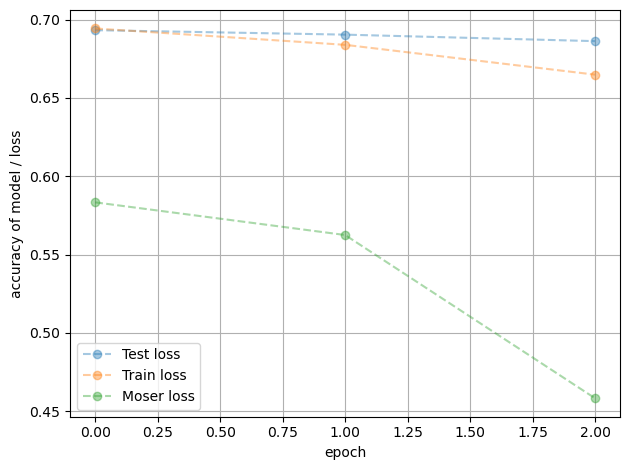

In [ ]:


# Set tracking URI
MODEL_REGISTRY = Path("experiments")
Path(MODEL_REGISTRY).mkdir(exist_ok=True) # create experiments dir
mlflow.set_tracking_uri("file://" + str(MODEL_REGISTRY.absolute()))
#print(str(MODEL_REGISTRY.absolute()))
#mlflow.set_tracking_uri("http://localhost:5000")

EXPERIMENT_NAME = "mlflow-demo"
#EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
EXPERIMENT_ID = mlflow.set_experiment(EXPERIMENT_NAME)
print(EXPERIMENT_ID)

#with mlflow.start_run(experiment_id=EXPERIMENT_ID):
with mlflow.start_run():
    # train and evaluate
    artifacts = train(batch_size, f, NUM_EPOCHS,N_STEPS_MOSER, path)
    # log key metrics
    #mlflow.log_param("f", f)
    #mlflow.log_param("batch_size", batch_size)
    #mlflow.log_param("NUM_EPOCHS", NUM_EPOCHS)

    mlflow.log_params({
                "f": f,
                "batch_size": batch_size,
                "NUM_EPOCHS": NUM_EPOCHS,
                "N_STEPS_MOSER": N_STEPS_MOSER,
        })
    #mlflow.log_dict("params", artifacts["params"])
    #mlflow.log_artifact()
    #log_artifacts
    #for eval_result in artifacts["eval_objects"]:
    #    print(f"{eval_result.name}: {eval_result.results[-1]}")
    # mlflow.log_metric(eval_result.name + "total", eval_result.results)
    with tempfile.TemporaryDirectory() as dp:
        joblib.dump(artifacts["params"], Path(dp, "params.pkl"))
        #save_dict(artifacts["params"], Path(dp, "params.json"))
        mlflow.log_artifact(dp)
    

In [ ]:
import pickle

with open("params.pkl", 'rb') as f:
    data = pickle.load(f)

print(data)

{'linear': {'b': DeviceArray([-0.00616598, -0.00491149,  0.00650048,  0.00600614,
              0.00716236, -0.00709248,  0.00550713,  0.00464901,
              0.00559845,  0.00403207, -0.00488615, -0.00407694,
             -0.00651171,  0.00313623,  0.00462502, -0.00606157],            dtype=float32), 'w': DeviceArray([[ 0.8756581 , -0.06096204,  0.55880845, -0.15074638,
              -0.38536552,  0.48313373, -0.67060333, -0.34809312,
               0.18987757, -0.5603848 ,  0.97394204,  0.01901448,
              -0.70707965, -0.53414214,  0.7468373 ,  0.92122084],
             [ 0.34014556, -0.62763673,  0.1279042 , -0.25236878,
              -0.11141646,  0.8397494 , -0.08280747, -0.48622668,
              -0.11242239, -0.2898999 ,  0.9415275 , -0.12136869,
               0.18164462, -0.2521023 ,  0.46865466,  0.72407794]],            dtype=float32)}, 'linear_1': {'b': DeviceArray([-4.7081918e-03,  1.6602013e-03,  3.4016604e-03,
             -4.6820110e-03, -2.2027967e-03,  2.8631

In [ ]:
mlflow server -h 0.0.0.0 -p 8000 --backend-store-uri $PWD/experiments/

SyntaxError: invalid syntax (3151842773.py, line 1)

In [ ]:
!npm install -g localtunnel

zsh:1: command not found: npm


In [ ]:

# Run MLFlow server and localtunnel
get_ipython().system_raw("mlflow server -h 0.0.0.0 -p 8001 --backend-store-uri $PWD/experiments/ &")
!npx localtunnel --port 8000

zsh:1: command not found: npx


[2023-01-11 10:24:36 +0100] [41151] [INFO] Starting gunicorn 20.1.0
[2023-01-11 10:24:36 +0100] [41151] [INFO] Listening at: http://0.0.0.0:8001 (41151)
[2023-01-11 10:24:36 +0100] [41151] [INFO] Using worker: sync
[2023-01-11 10:24:36 +0100] [41152] [INFO] Booting worker with pid: 41152
[2023-01-11 10:24:36 +0100] [41153] [INFO] Booting worker with pid: 41153
[2023-01-11 10:24:36 +0100] [41154] [INFO] Booting worker with pid: 41154
[2023-01-11 10:24:36 +0100] [41155] [INFO] Booting worker with pid: 41155


In [ ]:
n_literals = 4
n_node = 8 + 3
nodes = []
for i in range(n_node):
    if i<2*n_literals:
        if i%2 == 0:
            nodes.append(0)
        if i%2 == 1:
            nodes.append(-1)
    else:
        nodes.append(1)

print(nodes)

[0, -1, 0, -1, 0, -1, 0, -1, 1, 1, 1]


In [ ]:
import numpy as np
c = [1,-1/2,5]
print(((np.sign(c)+1) // 2).astype(np.int32))
print(((np.sign(c)+1)).astype(np.int32))

[1 0 1]
[2 0 2]


In [1]:
from data_utils import SATTrainingDataset

path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_medium_subset/"
sat_data = SATTrainingDataset(path)


print(sat_data[0])

j 0
support [0, 13, 23]
vals [ 1  1 -1]
30
[30 30 30]
j 1
support [10, 12, 20]
vals [-1 -1 -1]
31
[31 31 31]
j 2
support [13, 24, 25]
vals [ 1 -1  1]
32
[32 32 32]
j 3
support [1, 11, 27]
vals [1 1 1]
33
[33 33 33]
j 4
support [10, 16, 25]
vals [-1  1  1]
34
[34 34 34]
j 5
support [15, 18, 22]
vals [1 1 1]
35
[35 35 35]
j 6
support [0, 12, 27]
vals [-1 -1 -1]
36
[36 36 36]
j 7
support [8, 12, 20]
vals [ 1 -1 -1]
37
[37 37 37]
j 8
support [14, 19, 28]
vals [1 1 1]
38
[38 38 38]
j 9
support [0, 3, 9]
vals [ 1  1 -1]
39
[39 39 39]
j 10
support [3, 5, 8]
vals [ 1 -1 -1]
40
[40 40 40]
j 11
support [8, 23, 29]
vals [-1 -1  1]
41
[41 41 41]
j 12
support [6, 18, 19]
vals [-1  1 -1]
42
[42 42 42]
j 13
support [2, 3, 4]
vals [-1 -1 -1]
43
[43 43 43]
j 14
support [2, 15, 19]
vals [-1  1 -1]
44
[44 44 44]
j 15
support [1, 6, 7]
vals [ 1 -1 -1]
45
[45 45 45]
j 16
support [17, 19, 24]
vals [-1  1 -1]
46
[46 46 46]
j 17
support [5, 6, 18]
vals [1 1 1]
47
[47 47 47]
j 18
support [9, 17, 27]
vals [ 1 -

In [17]:
from data_utils import SATTrainingDataset, JraphDataLoader
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
from model import network_definition_GCN, network_definition_GCN_single_output
batch_size = 5
network_definition = network_definition_GCN_single_output
path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_medium_subset/"
sat_data = SATTrainingDataset(path)
print(sat_data)
# print(sat_data[0])
data_loader = JraphDataLoader(sat_data, batch_size=batch_size, shuffle=True)
# print(data_loader)

f=0.0001
network = hk.without_apply_rng(hk.transform(network_definition))
params = network.init(jax.random.PRNGKey(42), sat_data[0][0].graph)

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)


vmap_one_hot = jax.vmap(one_hot, in_axes=(0, None), out_axes=0)


def compute_log_probs(decoded_nodes, candidate):
    a = jax.nn.log_softmax(decoded_nodes) # * mask[:, None]
    return candidate * a


vmap_compute_log_probs = jax.vmap(
    compute_log_probs, in_axes=(None, 1), out_axes=1
)

def prediction_loss(params, batch, f: float):
        (mask, graph), (candidates, energies) = batch
        n = int(jnp.sum(mask)/2) # number of variables
        decoded_nodes = network.apply(params, graph)  # (B*2*N, 1)
        pos_nodes = decoded_nodes[0:n][:,0] 
        neg_nodes = decoded_nodes[n:2*n][:,0]
        conc_decoded_nodes = jnp.vstack((pos_nodes, neg_nodes)).T # (sum of variables in batch, n, 2)
        candidates = candidates[0:n, :] # (sum of variables in batch, K) # so we do not need the mask anymore
        candidates = vmap_one_hot(candidates, 2)  # (sum of variables in batch, K, 2))
        log_prob = vmap_compute_log_probs(conc_decoded_nodes, mask, candidates) # (sum of variables in batch, K, 2)
        weights = jax.nn.softmax(-f * energies)  # (sum of variables in batch, K)
        loss = -jnp.sum(weights * jnp.sum(log_prob, axis=-1)) / n # ()
        # jax.debug.print("🤯 {x} 🤯", x=loss)
        return loss
        

for counter, batch in enumerate(data_loader):
    prediction_loss(params, batch, f)


n= 30
m= 62
mode LCG
n= 50
m= 104
mode LCG
n= 30
m= 62
mode LCG
n= 30
m= 62
mode LCG
n= 30
m= 62
mode LCG
n= 30
m= 93
mode LCG
conc_dec_nodes (170, 2)
cand (170, 10)
candidates (170, 10, 2)
(170, 10, 2)
(170, 10)
()
0.6931475


In [2]:
from data_utils import SATTrainingDataset, JraphDataLoader
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
from model import network_definition_GCN, network_definition_GCN_single_output
batch_size = 4
network_definition = network_definition_GCN_single_output
path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_medium/"
sat_data = SATTrainingDataset(path)
print(sat_data)
# print(sat_data[0])
data_loader = JraphDataLoader(sat_data, batch_size=batch_size, shuffle=True)
# print(data_loader)

f=0.0001
network = hk.without_apply_rng(hk.transform(network_definition))
params = network.init(jax.random.PRNGKey(42), sat_data[0][0].graph)

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)


vmap_one_hot = jax.vmap(one_hot, in_axes=(0, None), out_axes=0)


def compute_log_probs(decoded_nodes, mask, candidate):
    a = jax.nn.log_softmax(decoded_nodes) * mask[:, None]
    return candidate * a


vmap_compute_log_probs = jax.vmap(
    compute_log_probs, in_axes=(None, None, 1), out_axes=1
)

def prediction_loss(params, batch, f: float):
        (mask, graph), (candidates, energies) = batch
        print()
        print(np.shape(mask))
        decoded_nodes = network.apply(params, graph)  # (B*2*N, 1)
        print(np.shape(decoded_nodes))
        # print(decoded_nodes)
        # conc_decoded_nodes = jnp.reshape(decoded_nodes, (int(np.shape(graph.nodes)[0]/2),2))
        if np.shape(decoded_nodes)[0]%2==1:
            conc_decoded_nodes = np.concatenate(decoded_nodes,[0])
        conc_decoded_nodes = jnp.reshape(decoded_nodes, (-1,2))
        print(np.shape(conc_decoded_nodes))
        # print(conc_decoded_nodes)
        pad_width = [(0,int(np.shape(graph.nodes)[0]/2)),(0,0)]
        padded_conc_decoded_nodes = np.pad(conc_decoded_nodes, pad_width, mode='constant')
        print(np.shape(padded_conc_decoded_nodes))
        candidates = vmap_one_hot(candidates, 2)
        log_prob = vmap_compute_log_probs(padded_conc_decoded_nodes, mask, candidates)
        print(np.shape(log_prob))
        weights = jax.nn.softmax(-f * energies)
        print(np.shape(weights))
        loss = -jnp.sum(weights * jnp.sum(log_prob, axis=-1)) # ()
        # jax.debug.print("🤯 {x} 🤯", x=loss)
        return loss
        

for counter, batch in enumerate(data_loader):
    prediction_loss(params, batch, f)

nodes 116
edges 228
nodes 28
edges 84
nodes 9
edges 27
nodes 73
edges 159
nodes 73
edges 159

(1132,)
(1132, 1)
(566, 2)
(1132, 2)
(1132, 10, 2)
(1132, 10)
nodes 69
edges 147
nodes 69
edges 147
nodes 20
edges 60
nodes 78
edges 174

(1132,)
(1132, 1)
(566, 2)
(1132, 2)
(1132, 10, 2)
(1132, 10)
nodes 59
edges 117
nodes 116
edges 228
nodes 58
edges 114
nodes 119
edges 237

(1132,)
(1132, 1)
(566, 2)
(1132, 2)
(1132, 10, 2)
(1132, 10)
nodes 126
edges 258
nodes 80
edges 180
nodes 10
edges 30
nodes 11
edges 33

(1132,)
(1132, 1)
(566, 2)
(1132, 2)
(1132, 10, 2)
(1132, 10)
nodes 75
edges 165
nodes 59
edges 117
nodes 76
edges 168
nodes 118
edges 234

(1132,)
(1132, 1)
(566, 2)
(1132, 2)
(1132, 10, 2)
(1132, 10)
nodes 82
edges 186
nodes 16
edges 48
nodes 32
edges 96
nodes 123
edges 249

(1132,)
(1132, 1)
(566, 2)
(1132, 2)
(1132, 10, 2)
(1132, 10)
nodes 115
edges 225
nodes 59
edges 117
nodes 65
edges 135
nodes 2
edges 6

(1132,)
(1132, 1)
(566, 2)
(1132, 2)
(1132, 10, 2)
(1132, 10)
nodes 117
ed

In [4]:
array = np.array([[1,2],[3,4]])
pad_width = [(0,2),(0,0)]
a  = np.pad(array, pad_width)

In [7]:
np.vstack((array,array))

array([[1, 2],
       [3, 4],
       [1, 2],
       [3, 4]])

In [2]:
from data_utils import SATTrainingDataset, JraphDataLoader
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
from model import network_definition_GCN, network_definition_GCN_single_output, network_definition_interaction_single_output
batch_size = 1
network_definition = network_definition_interaction_single_output
path = "/Users/p403830/Library/CloudStorage/OneDrive-PorscheDigitalGmbH/programming/generateSAT/samples_medium/"
sat_data = SATTrainingDataset(path)
# print(sat_data[0])
data_loader = JraphDataLoader(sat_data, batch_size=batch_size, shuffle=True)
# print(data_loader)

f=0.0001
network = hk.without_apply_rng(hk.transform(network_definition))
params = network.init(jax.random.PRNGKey(42), sat_data[0][0].graph)

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)


vmap_one_hot = jax.vmap(one_hot, in_axes=(0, None), out_axes=0)


def compute_log_probs(decoded_nodes, mask, candidate):
    a = jax.nn.log_softmax(decoded_nodes) * mask[:, None]
    return candidate * a


vmap_compute_log_probs = jax.vmap(
    compute_log_probs, in_axes=(None, None, 1), out_axes=1
)

def prediction_loss(params, batch, f: float):
        (mask, graph), (candidates, energies) = batch
        decoded_nodes = network.apply(params, graph)  # (B*2*N, 1)
        if np.shape(decoded_nodes)[0]%2==1:
            decoded_nodes = np.vstack((decoded_nodes,[0]))
            conc_decoded_nodes = jnp.reshape(decoded_nodes, (-1,2))
            padded_conc_decoded_nodes = jnp.concatenate((conc_decoded_nodes, conc_decoded_nodes))[:-1,:]
        else:
            conc_decoded_nodes = jnp.reshape(decoded_nodes, (-1,2))
            padded_conc_decoded_nodes = jnp.concatenate((conc_decoded_nodes, conc_decoded_nodes))
        print(padded_conc_decoded_nodes)
        candidates = vmap_one_hot(candidates, 2)
        log_prob = vmap_compute_log_probs(padded_conc_decoded_nodes, mask, candidates)
        weights = jax.nn.softmax(-f * energies)
        loss = -jnp.sum(weights * jnp.sum(log_prob, axis=-1)) / jnp.sum(mask)# ()
        # jax.debug.print("🤯 {x} 🤯", x=loss)
        return loss

for counter, batch in enumerate(data_loader):
    prediction_loss(params, batch, f)

[[-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [-1.5578742e-05  4.6168561e-06]
 [ 3.2889475e-05  5.7873644e-05]
 [ 3.3221531e-05  3.5587240e-05]
 [ 3.2321710e-05  3.4592449e-05]
 [ 2.0555657e-05  3.3260883e-05]
 [ 4.6320842e-05  4.7174588e-05]
 [ 4.71623